# Usage Example

- How to generate a DRR
- How to gradients with respect to DRR parameters

In [1]:
import matplotlib.pyplot as plt
import torch

from diffdrr import load_example_ct, DRR
from diffdrr.visualization import plot_drr

## DRR Generation

The generator is implemented as a custom PyTorch module.

All raytracing operations have been formulated in a vectorized function, enabling use of PyTorch's GPU support and autograd.
This also means that DRR generation is available as a layer in deep learning frameworks.

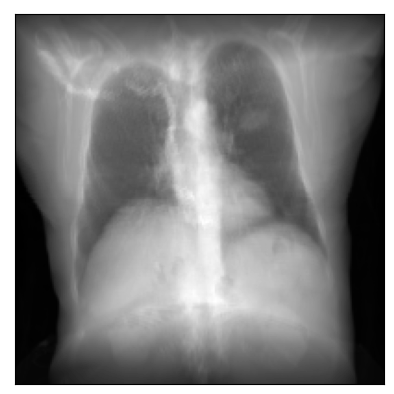

In [2]:
# Read in the volume
volume, spacing = load_example_ct()

# Get parameters for the detector
bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2
detector_kwargs = {
    "sdr"   : 300.0,
    "theta" : torch.pi,
    "phi"   : 0,
    "gamma" : torch.pi / 2,
    "bx"    : bx,
    "by"    : by,
    "bz"    : bz,
}

# Make the DRR
drr = DRR(volume, spacing, height=200, delx=4.0, device="cuda")
img = drr(**detector_kwargs)  # Parameters need to be initialized only once
ax = plot_drr(img, ticks=False)
plt.savefig("../figures/example_DRR.pdf", bbox_inches="tight")
plt.show()

Timing results are on a single NVIDIA RTX 2080 Ti GPU.

In [3]:
%timeit drr()
del drr

33.4 ms ± 91.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


You can also render sparse subsets of the pixels in a DRR. This is useful for speeding up registration and registration tasks.

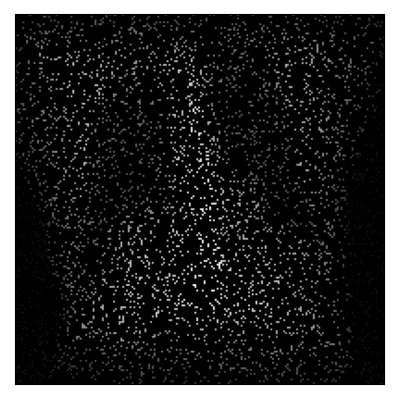

In [4]:
# Make the DRR with 10% of the pixels
drr = DRR(volume, spacing, height=200, delx=4.0, p_subsample=0.1, device="cuda")
img = drr(**detector_kwargs)  # Parameters need to be initialized only once
ax = plot_drr(img, ticks=False)
plt.show()

In [5]:
%timeit drr()

6.65 ms ± 55.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Gradients

Gradients of input parameters are computable with autograd.

In [6]:
torch.autograd.set_detect_anomaly(True)

img.mean().backward(retain_graph=True)
drr.rotations.grad, drr.translations.grad

(tensor([[1752.2817, -101.2656,  595.3546]], device='cuda:0'),
 tensor([[78.5704, -0.6954, -2.6839]], device='cuda:0'))

## Try the M1 GPU

Certain PyTorch functions have not yet been ported :(

In [5]:
# Make DRR
drr = DRR(volume, spacing, height=200, delx=1.4e-2, device="mps")
img = drr(**detector_kwargs)

plot_drr(drr)
plt.show()

ValueError: mps is not available